# Full and Fractional Factorial Designs

BoFire can be used to setup full (two level) and fractional factorial designs (https://en.wikipedia.org/wiki/Fractional_factorial_design). This tutorial notebook shows how.

## Imports and helper functions

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import bofire.strategies.api as strategies
from bofire.data_models.domain.api import Domain
from bofire.data_models.features.api import CategoricalInput, ContinuousInput
from bofire.data_models.strategies.api import FractionalFactorialStrategy
from bofire.utils.doe import get_alias_structure, get_confounding_matrix, get_generator


def plot_design(design: pd.DataFrame):
    # we do a plot with three subplots in one row in which the three degrees of freedom (temperature, time and ph) are plotted
    _, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].scatter(design["temperature"], design["time"])
    axs[0].set_xlabel("Temperature")
    axs[0].set_ylabel("Time")
    axs[1].scatter(design["temperature"], design["ph"])
    axs[1].set_xlabel("Temperature")
    axs[1].set_ylabel("pH")
    axs[2].scatter(design["time"], design["ph"])
    axs[2].set_xlabel("Time")
    axs[2].set_ylabel("pH")
    plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/bofire-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup the problem domain

The designs are generated for a simple three dimensional problem comprised of three continuous factors/features.

In [ ]:
domain = Domain(
    inputs=[
        ContinuousInput(key="temperature", bounds=(20, 80)),
        ContinuousInput(key="time", bounds=(60, 120)),
        ContinuousInput(key="ph", bounds=(7, 13)),
    ],
)

## Setup a full factorial design

Here we setup a full two-level factorial design including a center point and plot it. 

,ph,temperature,time
0,7.0,20.0,60.0
1,7.0,20.0,120.0
2,7.0,80.0,60.0
3,7.0,80.0,120.0
4,13.0,20.0,60.0
5,13.0,20.0,120.0
6,13.0,80.0,60.0
7,13.0,80.0,120.0
8,10.0,50.0,90.0


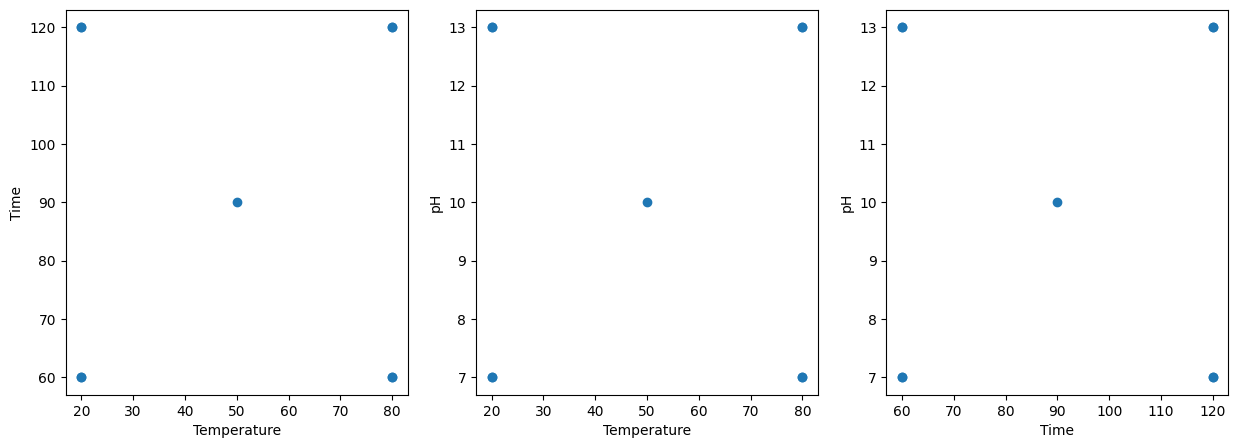

In [ ]:
strategy_data = FractionalFactorialStrategy(
    domain=domain,
    n_center=1,  # number of center points
    n_repetitions=1,  # number of repetitions, we do only one round here
)
strategy = strategies.map(strategy_data)
design = strategy.ask()
display(design)

plot_design(design=design)

The confounding structure is shown below, as expected for a full factorial design, no confound is present.

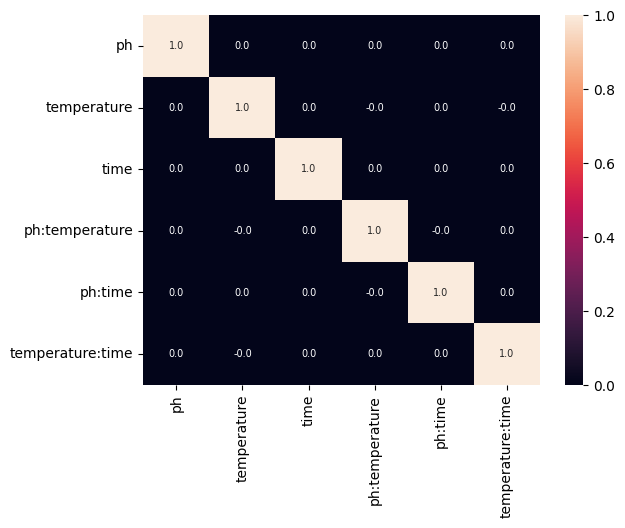

In [ ]:
m = get_confounding_matrix(domain.inputs, design=design, interactions=[2])

sns.heatmap(m, annot=True, annot_kws={"fontsize": 7}, fmt="2.1f")
plt.show()

## Setup a full factorial design with blocking

Here we setup a blocked full two-level factorial design including a center point and plot it. 

,ph,temperature,time,operator
0,7.0,20.0,60.0,A
1,13.0,80.0,120.0,A
2,10.0,50.0,90.0,A
3,7.0,20.0,120.0,B
4,13.0,80.0,60.0,B
5,10.0,50.0,90.0,B
6,7.0,80.0,60.0,C
7,13.0,20.0,120.0,C
8,10.0,50.0,90.0,C
9,7.0,80.0,120.0,D


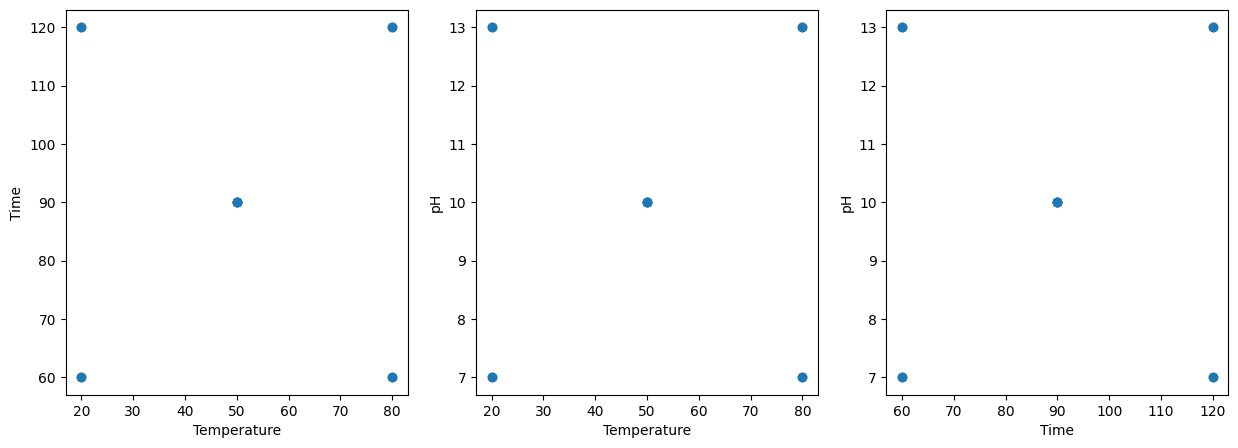

In [ ]:
blocked_domain = Domain(
    inputs=[
        ContinuousInput(key="temperature", bounds=(20, 80)),
        ContinuousInput(key="time", bounds=(60, 120)),
        ContinuousInput(key="ph", bounds=(7, 13)),
        CategoricalInput(key="operator", categories=["A", "B", "C", "D"]),
    ],
)


strategy_data = FractionalFactorialStrategy(
    domain=blocked_domain,
    n_center=1,  # number of center points per block
    n_repetitions=1,  # number of repetitions, we do only one round here
    block_feature_key="operator",
)
strategy = strategies.map(strategy_data)
design = strategy.ask()
display(design)

plot_design(design=design)

## Setup a fractional factorial design

Here a fractional factorial design of the form $2^{3-1}$ is setup by specifying the number of generators (here 1). In comparison to the full factorial design with 9 candidates, it features only 5 experiments.

In [ ]:
strategy_data = FractionalFactorialStrategy(
    domain=domain,
    n_center=1,  # number of center points
    n_repetitions=1,  # number of repetitions, we do only one round here
    n_generators=1,  # number of generators, ie number of reducing factors
)
strategy = strategies.map(strategy_data)
design = strategy.ask()
display(design)

The generator string is automatically generated by making use of the method `get_generator` and specifying the total number of factors (here 3) and the number of generators (here 1).

In [ ]:
get_generator(n_factors=3, n_generators=1)

As expected for a type III design the main effects are confounded with the two factor interactions:

In [ ]:
m = get_confounding_matrix(domain.inputs, design=design, interactions=[2])

sns.heatmap(m, annot=True, annot_kws={"fontsize": 7}, fmt="2.1f")
plt.show()

This can also be expressed by the so called alias structure that can be calculated as following:

In [ ]:
get_alias_structure("a b ab")

Here again a fractional factorial design of the form $2^{3-1}$ is setup by providing the complete generator string of the form `a b -ab` explicitly to the strategy.

In [ ]:
strategy_data = FractionalFactorialStrategy(
    domain=domain,
    n_center=1,  # number of center points
    n_repetitions=1,  # number of repetitions, we do only one round here
    generator="a b -ab",  # the exact generator
)
strategy = strategies.map(strategy_data)
design = strategy.ask()
display(design)

The last two designs differ only in the last feature `time`, since the generator strings are different. In the first one it holds `time=ph x temperature` whereas in the second it holds `time=-ph x temperature`, which is also reflected in the confounding structure.

In [ ]:
m = get_confounding_matrix(domain.inputs, design=design, interactions=[2])

sns.heatmap(m, annot=True, annot_kws={"fontsize": 7}, fmt="2.1f")
plt.show()